In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models

2024-05-05 01:21:03.816190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 01:21:04.803237: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-05 01:21:04.803356: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-05-05 01:21:04.803370: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from xgboost import XGBClassifier
from scipy.linalg import null_space
from sklearn.cross_decomposition import CCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
import pickle
import json

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
with open('./chem/train.csv', 'r') as f:
  dataX = np.float32(np.array([line.strip().split(',')[2:] for line in f])[1:])

with open('./chem/train.csv', 'r') as f:
  dataY = np.float32(np.array([line.strip().split(',')[1] for line in f])[1:])

X = dataX
Y = dataY

In [8]:
with open('./chem/val_ood.csv', 'r') as f:
  external_X = np.float32(np.array([line.strip().split(',')[4:] for line in f])[1:])

with open('./chem/val_ood.csv', 'r') as f:
  external_Y = np.float32(np.array([line.strip().split(',')[1] for line in f])[1:])


In [9]:
# standardize the data
mu_x = np.mean(X, 0, keepdims=True)
# sigma_x = np.std(X, 0, keepdims=True)
sigma_x = np.ones_like(mu_x)
X = (X-mu_x)/sigma_x

In [10]:
print(X.shape)
print(Y.shape)

(5997, 1024)
(5997,)


In [11]:
class RandFeats:
  # def __init__(self, sigma_rot, d, D=196):
  def __init__(self, sigma_rot, d, D=128):

    self.sigmas = [sigma_rot/4, sigma_rot/2, sigma_rot, sigma_rot*2, sigma_rot*4]
    self.D = D
    self.Ws = []
    for sigma in self.sigmas:
      self.Ws.append(np.float32(np.random.randn(d, D)/sigma))
    self.Ws = np.stack(self.Ws, 0)

  def get_features(self, x_in):
    # phis = []
    # TODO: vectorize
    # for W in Ws:
    #   XW = np.matmul(x_in, W)
    #   phis.append(
    #     np.concatenate([np.sin(XW), np.cos(XW)], -1))
    # return np.concatenate(phis, -1)
    phis = tf.matmul(x_in, self.Ws)  # k x N x D
    phis = tf.transpose(phis, [1, 2, 0])  # N x D x k
    phis = tf.concat((tf.sin(phis), tf.cos(phis)), 1)
    return tf.reshape(phis, [x_in.shape[0], -1])

  def __call__(self, x_in):
    return self.get_features(x_in)

# def define_rand_feats(ndata_feats, nrand_feats=1000, gamma=1.0):
def define_rand_feats(X, xD):
  """
  Args:
    ndata_feats: scalar value of total number of data features
    nrand_feats: scalar value of total number of desired random features
    gamma: Float, scale of frequencies

  Returns:
    Ws: ndata_feats x nrand_feats weight matrix
    bs: 1 x nrand_feats bias vector
  """
  tf.random.set_seed(123129) # For reproducibility
  from scipy.spatial import distance
  rprm = np.random.permutation(X.shape[0])
  ds = distance.cdist(X[rprm[:100], :], X[rprm[100:], :])
  sigma_rot = np.mean(np.sort(ds)[:, 5])
  model = RandFeats(sigma_rot, X.shape[1], int(X.shape[1]*xD))

  # Ws = gamma*tf.random.normal((ndata_feats, nrand_feats))
  # bs = 2.0*np.pi*tf.random.uniform((1,nrand_feats))
  # return Ws, bs
  return model

In [12]:
Dx = [1.5, 2, 4, 8, 10, 16]

In [13]:
def get_rand_feats(X, model):
  """
  Args:
    X: N x d matrix of input features
    Ws: ndata_feats x nrand_feats weight matrix
    bs: 1 x nrand_feats bias vector

  Returns:
    Phis: N x D matrix of random features
  """
  # XWs = tf.matmul(X, Ws)
  # return tf.cos(XWs+bs)
  return model(X)

In [14]:
def linear_coefs(X, Y):
  """
  Args:
    X: N x d matrix of input features
    Y: N x 1 matrix (column vector) of output response

  Returns:
    Beta: d x 1 matrix of linear coefficients
  """
  clf = LogisticRegression(random_state=0, solver='liblinear').fit(X, Y)
  print(clf.score(X, Y))
  wgts = np.hstack((clf.intercept_[:,None], clf.coef_))
  prd = (1 / (1 + np.exp(-np.concatenate([np.ones((X.shape[0], 1)), X], axis=-1) @ wgts.T)) > 0.5) *1.0
  # print((prd[:, 0]==Y).mean())
  return wgts
  # beta = tf.linalg.solve(tf.matmul(tf.transpose(X),X), tf.matmul(tf.transpose(X), Y[:, None]))
  # return beta

In [15]:
def project_and_filter(X, dir, percentile=75):
  projs = np.dot(X, dir)
  thresh = np.percentile(projs, 100 - percentile)
  filtered_idxs = projs >= thresh
  return X[filtered_idxs], filtered_idxs

In [16]:
def get_models(X, Y, pca_projs, dirs, model, percentile=75):
  #X_subsets = []
  #data_ids = []
  #Y_subsets = []
  betas = []
  i = 0
  for dir in dirs: # TODO: Vectorize
    if i % 25 == 0: print(f"Step {i}")
    X_sub, X_ids = project_and_filter(X, dir, percentile)
    Y_sub = Y[X_ids]
    # print((X_sub@pca_projs).shape)
    beta = linear_coefs(get_rand_feats(X_sub@pca_projs, model), Y_sub)
    # print(beta.shape)
      
    #X_subsets.append(X_sub)
    #data_ids.append(X_ids)
    #Y_subsets.append(Y_sub)
    betas.append(beta)
    i += 1
    if i == len(dirs) - 1: print(f"Done")

  # cant do this because subsets of variable sizes
  #X_subsets = np.array(X_subsets)
  #data_ids = np.array(data_ids)
  #Y_subsets = np.array(Y_subsets)
  betas = np.array(betas)

  return betas
  #return X_subsets, data_ids, Y_subsets, betas

In [17]:
X.shape

(5997, 1024)

In [18]:
s, u, v = tf.linalg.svd(X)

2024-05-05 01:21:13.007883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 01:21:13.180080: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9803 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:0a:00.0, compute capability: 7.5
2024-05-05 01:21:13.378203: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x9376e20


In [19]:
print(s[1])

tf.Tensor(232.08453, shape=(), dtype=float32)


In [20]:
dims = [0.05, 0.2, 0.3, 0.4, 0.8]
pca_projs = v[:, :int(X.shape[-1]*dims[1])]

In [21]:
X.shape, pca_projs.shape

((5997, 1024), TensorShape([1024, 204]))

In [22]:
np.random.seed(74)
X_prjs = np.array(X@pca_projs)
# model = define_rand_feats(X_prjs, Dx[2])
model = define_rand_feats(X_prjs, 2)

N = 2**9    # ~ 8k
# N = 2**2    # ~ 8k
d = X.shape[-1]
random_dirs = np.random.randn(N, d) # Maybe do the random directions in the random feature space??? Feel like that makes more sense

random_dirs = random_dirs / np.linalg.norm(random_dirs, axis=1, keepdims=True)

#X_subsets, data_ids, Y_subsets, betas = get_models(X, Y, random_dirs, Ws, bs, percentile=33)
betas = get_models(X, Y, pca_projs, random_dirs, model, percentile=40)

Step 0


KeyboardInterrupt: 

In [62]:
# np.save('random_dirs-chem2.npy', random_dirs)
# np.save('betas-chem2.npy', betas)
# np.save('Ws-chem2.npy', model.Ws)


In [25]:
random_dirs = tf.constant(np.load('./random_dirs-chem2.npy'))
betas = tf.squeeze(tf.constant(np.load('./betas-chem2.npy')))
model = define_rand_feats(X_prjs, 2)
model.Ws = tf.constant(np.load('./Ws-chem2.npy'))

In [80]:
np.allclose(random_dirs1, random_dirs)

True

In [81]:
np.sum(random_dirs1 - random_dirs)

0.0

In [26]:
betas = tf.squeeze(betas)
print(betas.shape)
random_dirs = tf.constant(random_dirs)
print(random_dirs.shape)

(512, 4081)
(512, 1024)


In [27]:
var = tf.math.reduce_variance(betas, axis=0)
mean_var = tf.reduce_mean(var)
print(mean_var)

tf.Tensor(0.01111806548776194, shape=(), dtype=float64)


In [28]:
sample = 1
def softmax(X, wgts):
  sd = (1 / (1 + np.exp(-np.concatenate([np.ones((X.shape[0], 1)), X], axis=-1) @ wgts.numpy().T)) > 0.5) *1.0
  return sd[:]

X_sub, X_ids = project_and_filter(X, random_dirs1[sample], 40)
Y_sub = Y[X_ids]
prd = softmax(get_rand_feats(X_sub@pca_projs, model), betas1[sample])

(prd == Y_sub).mean()

0.9958333333333333

In [29]:
ex_X = tf.cast(external_X, tf.float32)
ex_Y = external_Y
ex_X = (ex_X-mu_x)/sigma_x

X_sub, X_ids = project_and_filter(ex_X, random_dirs[sample], 70)
Y_sub = ex_Y[X_ids]
prd = softmax(get_rand_feats(X_sub@pca_projs, model), betas[sample])

(prd == Y_sub).mean()

0.6204268292682927

## Should test Betas performance first

In [35]:
from tensorflow.keras import layers, models

beta_dim = betas.shape[-1]
input_dir_dim = random_dirs.shape[-1]
latent_dim = 32

# Encoder
beta_input = layers.Input(shape=(beta_dim,))
beta_x = layers.Dense(512, activation=tf.nn.elu)(beta_input)
dir_input = layers.Input(shape=(input_dir_dim,))
encoder_inputs = layers.Concatenate()([beta_x, dir_input])
# x = layers.Dense(1024, activation=tf.nn.elu)(encoder_inputs)
x = layers.Dense(512, activation=tf.nn.elu)(encoder_inputs)
# x = layers.Dense(256, activation=tf.nn.elu)(x)
x = layers.Dense(128, activation=tf.nn.elu)(x)
x = layers.Dense(32, activation=tf.nn.elu)(x)
# x = layers.Dense(64, activation=tf.nn.elu)(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

def sampling(args):
  z_mean, z_log_var = args
  eps = tf.random.normal(shape=tf.shape(z_mean))
  return z_mean + tf.exp(0.5 * z_log_var) * eps

z = layers.Lambda(sampling)([z_mean, z_log_var])


### Using direction in Decoder is weird
### Likely just train VAE solely on betas with directions


# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
decoder_dir_input = layers.Input(shape=(input_dir_dim,))
decoder_inputs = layers.Concatenate()([latent_inputs, decoder_dir_input])
# x = layers.Dense(64, activation=tf.nn.elu)(decoder_inputs)
x = layers.Dense(32, activation=tf.nn.elu)(decoder_inputs)
# x = layers.Dense(128, activation=tf.nn.elu)(x)
x = layers.Dense(256, activation=tf.nn.elu)(x)
x = layers.Dense(512, activation=tf.nn.elu)(x)
# x = layers.Dense(1024, activation=tf.nn.elu)(x)
beta_output = layers.Dense(beta_dim)(x)

# Instantiate model
encoder = models.Model([beta_input, dir_input], [z_mean, z_log_var, z], name="encoder")
decoder = models.Model([latent_inputs, decoder_dir_input], beta_output, name="decoder")

# VAE
outputs = decoder([encoder([beta_input, dir_input])[2], dir_input])
vae = models.Model([beta_input, dir_input], outputs, name="vae")
vae.encoder = encoder
vae.decoder = decoder

In [36]:
def vae_loss(inputs, outputs, z_mean, z_log_var, reg=1.0):
  # recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(inputs - outputs), axis=-1))
  recon_loss = tf.reduce_mean(1-tf.reduce_sum(tf.linalg.normalize(tf.cast(inputs, dtype=tf.float32), axis=-1)[0] *
                                              tf.linalg.normalize(outputs, axis=-1)[0], axis=-1))
  kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))
  # total_loss = recon_loss + 0.05 * kl_loss
  total_loss = recon_loss + 0.005 * kl_loss
  return total_loss, recon_loss, kl_loss

In [37]:
opt = tf.keras.optimizers.Adam()

def train_step(model, inputs, dir_inputs):
  with tf.GradientTape() as tape:
    z_mean, z_log_var, z = model.encoder([inputs, dir_inputs])
    outputs = model.decoder([z, dir_inputs])
    total_loss, recon_loss, kl_loss = vae_loss(inputs, outputs, z_mean, z_log_var)
  grads = tape.gradient(total_loss, model.trainable_variables)
  opt.apply_gradients(zip(grads, model.trainable_variables))
  return total_loss, recon_loss, kl_loss

In [38]:
def batch(betas, dirs, batch_size):
  num_samples = betas.shape[0]
  indices = np.arange(num_samples)
  np.random.shuffle(indices)
  betas = np.array(betas)[indices]
  dirs = np.array(dirs)[indices]
  for i in range(0, betas.shape[0], batch_size):
    yield tf.constant(betas[i:i+batch_size]), tf.constant(dirs[i:i+batch_size])

In [39]:
epochs = 2000
batch_size = 32

for i in range(epochs):
  print(f"Epoch {i}")
  for step, (batch_betas, batch_dirs) in enumerate(batch(betas, random_dirs, batch_size)):
    loss_vals = train_step(vae, batch_betas, batch_dirs)
    if step % 100 == 0: # tmp
      print(f"Step {step}: loss = {loss_vals[0].numpy()}, recon_loss = {loss_vals[1].numpy()}, kl_loss = {loss_vals[2].numpy()}")
  print()

Epoch 0
Step 0: loss = 0.999082088470459, recon_loss = 0.996230959892273, kl_loss = 0.5702270865440369

Epoch 1
Step 0: loss = 0.4513305127620697, recon_loss = 0.41232872009277344, kl_loss = 7.800360679626465

Epoch 2
Step 0: loss = 0.42799705266952515, recon_loss = 0.4058411419391632, kl_loss = 4.431185245513916

Epoch 3
Step 0: loss = 0.4310673475265503, recon_loss = 0.40511810779571533, kl_loss = 5.189845561981201

Epoch 4
Step 0: loss = 0.43990251421928406, recon_loss = 0.4051375985145569, kl_loss = 6.952983856201172

Epoch 5
Step 0: loss = 0.42221516370773315, recon_loss = 0.4055999517440796, kl_loss = 3.323042392730713

Epoch 6
Step 0: loss = 0.42366519570350647, recon_loss = 0.4046902656555176, kl_loss = 3.7949881553649902

Epoch 7
Step 0: loss = 0.42843925952911377, recon_loss = 0.4035003185272217, kl_loss = 4.987785339355469

Epoch 8
Step 0: loss = 0.4136664569377899, recon_loss = 0.3992936313152313, kl_loss = 2.874565601348877

Epoch 9
Step 0: loss = 0.41961386799812317, reco

KeyboardInterrupt: 

In [ ]:
vae.save_weights('./my_checkpoint/chekpont')

In [ ]:
vae.load_weights('./my_checkpoint/chekpont')

In [ ]:
# !zip -r my_checkpoint.zip my_checkpoint/
!unzip chem-checkpoint.zip

Archive:  chem-checkpoint.zip
   creating: my_checkpoint/
  inflating: my_checkpoint/chekpont.index  
  inflating: my_checkpoint/.data-00000-of-00001  
  inflating: my_checkpoint/checkpoint  
  inflating: my_checkpoint/chekpont.data-00000-of-00001  
  inflating: my_checkpoint/.index    


In [ ]:
random_dirs = np.random.randn(50_000, d)

In [109]:
# Dont really think this works, since the latent space should be conditioned on the direction
# Just to try something
# Likely better to just have VAE solely on betas w/o directions

def generate_new_betas(model, rdirs, num_samples=1):
  random_dirs1 = rdirs
  random_dirs2 = random_dirs1 + np.random.randn(num_samples, d)*0.05
  random_dirs1 = random_dirs1 / np.linalg.norm(random_dirs1, axis=1, keepdims=True)
  random_dirs1 = tf.constant(random_dirs1)
  random_dirs2 = random_dirs2 / np.linalg.norm(random_dirs2, axis=1, keepdims=True)
  random_dirs2 = tf.constant(random_dirs2)
  latent_samples1 = tf.random.normal(shape=(num_samples, latent_dim))
  latent_samples2 = tf.random.normal(shape=(num_samples, latent_dim))
  # latent_samples = tf.ones_like(tf.random.normal(shape=(num_samples, latent_dim)))
  return model.decoder([latent_samples1, random_dirs1]), random_dirs1, model.decoder([latent_samples2, random_dirs2])

In [110]:
# drawn_betas1, dir1, drawn_betas2 = generate_new_betas(vae, np.random.randn(50_0, d), 50_0) ## too much change between this and below
drawn_betas1, dir1, drawn_betas2 = generate_new_betas(vae, random_dirs, len(random_dirs)) ## recall posterior sampling high correlation as well
## even slight 0.5 deviations from training random directions totally changes the beta directions correlations hence not very stable 
## with resoect to training dircetions overfitting too much

In [111]:
tf.keras.losses.CosineSimilarity(axis=-1)(drawn_betas1, drawn_betas2)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.5788343>

In [ ]:
drawn_betas1[0:3]

<tf.Tensor: shape=(3, 1793), dtype=float32, numpy=
array([[  1.1108708 ,  -1.0370612 ,   1.0474906 , ...,  -8.708343  ,
         -2.0336905 ,   0.90315366],
       [  0.59400725,  -4.0057716 ,  -8.4961195 , ..., -12.938477  ,
         20.990461  ,  -5.11088   ],
       [  1.6494957 ,  -0.9708191 , -10.286863  , ...,  15.719532  ,
         -2.167779  ,   1.6435473 ]], dtype=float32)>

In [ ]:
var = tf.math.reduce_variance(drawn_betas1, axis=0)
mean_var = tf.reduce_mean(var)
print(mean_var)

tf.Tensor(53.601833, shape=(), dtype=float32)


In [ ]:
np.mean(drawn_betas1 @ tf.transpose(drawn_betas))

In [ ]:
ood_val_features = convert_data_to_features(ood_val_data)
#ood_test_features = convert_data_to_features(ood_test_data)

ood_val_labels = np.array([entry['cls_label'] for entry in ood_val_data])
#ood_test_labels = np.array([entry['cls_label'] for entry in ood_test_data])

NameError: name 'convert_data_to_features' is not defined

In [ ]:
external_X = tf.cast(ood_val_features, tf.float32)
external_Y = ood_val_labels

In [106]:
external_X = (external_X-mu_x)/sigma_x
external_randfeats_X = get_rand_feats(external_X@pca_projs, model)
randfeats_X = get_rand_feats(X@pca_projs, model)

In [139]:
print(external_X[0])
print(external_randfeats_X[0][:10])
print(external_Y[0])

[ 1.9594797  -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
 -0.03134901]
tf.Tensor(
[-0.13125554  0.30866534  0.63319725 -0.5780234  -0.21648076 -0.3846287
  0.99320394 -0.1799166   0.678208    0.62888056], shape=(10,), dtype=float32)
0.0


In [138]:
print(external_X.shape)
print(external_randfeats_X.shape)
print(external_Y.shape)

(937, 1024)
(937, 2040)
(937,)


In [137]:
print(external_X[:10])
print(external_Y[:10])

[[ 1.9594797  -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
  -0.03134901]
 [-0.04052026 -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
  -0.03134901]
 [-0.04052026 -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
  -0.03134901]
 ...
 [-0.04052026 -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
  -0.03134901]
 [-0.04052026 -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
  -0.03134901]
 [-0.04052026 -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
  -0.03134901]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [107]:
def get_preds(randfeats, betas):
  """
  Args:
    randfeats: N x d
    betas: M x d
  Return:
    preds: N x M - each beta predicts on each instance
  """
  #preds = []
  #for i in range(len(betas)):
  #  if i % 25_000 == 0: print(f"{i} Predictions Made")
  #  preds.append(np.matmul(randfeats, betas[i]))
  #return np.array(preds)
  sd = (1 / (1 + np.exp(-np.concatenate([np.ones((randfeats.shape[0], 1)), randfeats], axis=-1) @ betas.numpy().T)))
  return sd[:]

  # betaT = np.transpose(betas) # d x M
  # preds = np.matmul(randfeats, betaT) # N x M
  # return preds

def aggregate_preds(preds):
  # mean_pred = np.mean(preds, axis=-1, keepdims=False)
  mean_pred = np.sum(preds, axis=-1, keepdims=False)
  std_pred = np.std(preds, axis=-1, keepdims=False)
  # Typically 0.5 threshold, just was all 0s
  return np.float32(mean_pred), np.float32(mean_pred), np.float32(std_pred)

def get_preds_and_aggregate_sorted(randfeats, eX, dirs, betas):
  preds = get_preds(randfeats, betas)
  projs = np.dot(tf.linalg.normalize(eX, axis=-1)[0], tf.transpose(tf.linalg.normalize(dirs, axis=-1)[0]))
  print(projs.shape, preds.shape)
  thresh = np.percentile(projs, 100 - 40, axis=-1)
  # wghts = (projs > thresh[:, None]) * projs
  wghts = tf.ones_like(projs > thresh[:, None])
  # wghts = (projs > thresh[:, None]).astype(np.float64)
  wghts /= np.sum(wghts, axis=-1, keepdims=True)
  return aggregate_preds(preds * wghts)

def get_preds_and_aggregate(randfeats, betas):
  preds = get_preds(randfeats, betas)
  return *aggregate_preds(preds), preds


ext_probs, mp_rand, sp_rand = get_preds_and_aggregate_sorted(external_randfeats_X, external_X, random_dirs, betas) # 0.622
# ext_preds, mp_rand, sp_rand = get_preds_and_aggregate(external_randfeats_X, drawn_betas1) # 0.622
# ext_preds, mp_rand, sp_rand = get_preds_and_aggregate(external_randfeats_X, betas) # 0.634
# ext_preds, mp_rand, sp_rand = get_preds_and_aggregate(randfeats_X, drawn_betas) # 0.85
# ext_preds, mp_rand, sp_rand = get_preds_and_aggregate(randfeats_X, betas) # 0.91

(937, 512) (937, 512)


In [ ]:
np.dot(tf.linalg.normalize(tf.ones((100, 200)), axis=-1)[0], tf.transpose(tf.linalg.normalize(tf.ones((100, 200)), axis=-1)[0])).shape

(100, 100)

In [ ]:
drawn_betas[0].numpy(), betas[0].numpy()

(array([ 1.767455  ,  0.1001012 , -0.54182774, ..., -6.8707843 ,
         7.257238  , -0.5050444 ], dtype=float32),
 array([-0.0186294 ,  0.06830448, -0.27256313, ..., -0.72351612,
         0.81710885,  0.05805234]))

In [ ]:
print(ext_preds.shape)

(937,)


In [72]:
print(ext_preds)

[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1.
 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.

In [108]:
# testing_Y = Y
ext_preds = ext_probs > 0.5
testing_Y = external_Y

print("First 10 Predictions: ", ext_preds[:10])
print("Total Positive Preds: ", sum(ext_preds))
print("Total Preds: ", len(ext_preds))
print("% Positive Preds: ", sum(ext_preds) / len(ext_preds))
print()
print("First 10 Ground Truth: ", testing_Y[:10])
print("Total Positive Ground Truth: ", sum(testing_Y))
print("Total Ground Truth: ", len(testing_Y))
print("% Positive Ground Truth: ", sum(testing_Y) / len(testing_Y))
print()
print("Accuracy: ", sum(ext_preds == testing_Y) / len(ext_preds))

First 10 Predictions:  [False  True False False  True False False False False False]
Total Positive Preds:  436
Total Preds:  937
% Positive Preds:  0.46531483457844186

First 10 Ground Truth:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total Positive Ground Truth:  421.0
Total Ground Truth:  937
% Positive Ground Truth:  0.44930629669156885

Accuracy:  0.6339381003201707


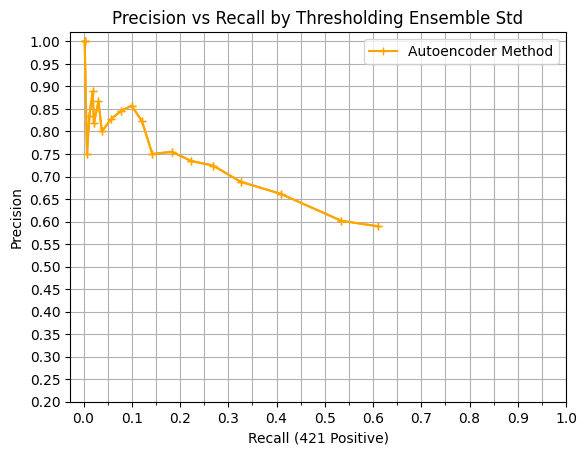

In [109]:
threshs = sp_rand
std_threshs = np.linspace(np.min(threshs), np.max(threshs), 20) # Diff std. dev. thresholds (20 of them in this case)
reject_rate = [1 - np.mean((threshs<=s)) for s in std_threshs] # Portion of instances rejected @ each std threshold
accus = [np.mean((ext_preds==external_Y)[(threshs<=s)]) for s in std_threshs] # Acc @ each std thresh.
tps = [np.sum(((external_Y)*(ext_preds==external_Y))[(threshs<=s)]) for s in std_threshs]  # correct and positive
fps = [np.sum(((ext_preds)*(ext_preds!=external_Y))[(threshs<=s)]) for s in std_threshs]  # incorrect and predicted positive
pos = np.sum(external_Y)
recall = [tp/pos for tp in tps]
precision = [tp/(tp+fp) for tp, fp in zip(tps, fps)]
plt.plot(recall, precision, marker='+', c='orange')

plt.plot(recall, precision, marker='+', c='orange')
plt.xticks(np.arange(0, 1.01, step=0.1))
plt.xticks(np.arange(0, 1.01, step=0.05), minor=True)
plt.yticks(np.arange(.2, 1.01, step=0.05))
plt.grid(True, which='both')
plt.xlabel('Recall ({} Positive)'.format(int(pos)))
plt.ylabel('Precision')
plt.title('Precision vs Recall by Thresholding Ensemble Std')
plt.legend(['Autoencoder Method'])

In [135]:
print(accus)

[1.0, 0.8, 0.6666666666666666, 0.6153846153846154, 0.5909090909090909, 0.4838709677419355, 0.4791666666666667, 0.4918032786885246, 0.5194805194805194, 0.5145631067961165, 0.48854961832061067, 0.46296296296296297, 0.4675925925925926, 0.45864661654135336, 0.4735202492211838, 0.47214854111405835, 0.4678111587982833, 0.4698581560283688, 0.4535031847133758, 0.44930629669156885]


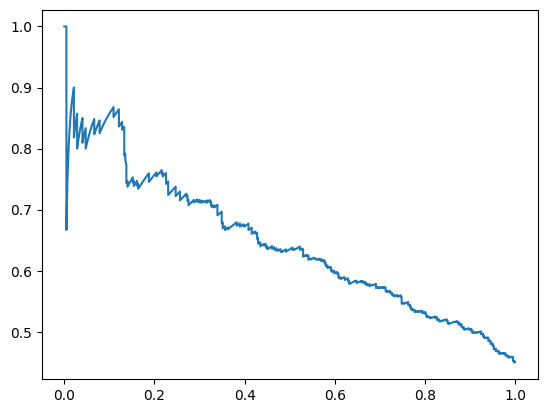

In [110]:
from sklearn.metrics import precision_recall_curve
p, r, thres = precision_recall_curve(external_Y, ext_probs)

plt.plot(r, p)